# Liner Inspection Project

## Main Libraries

In [2]:
import cv2
import glob
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt


## Main Functions

* `hough_circle_kwargs(img)`: Calculate HoughCircles parameters based on the input image.
* `draw_cap_circle(image, cap_mouth_circle)`: Draw the cap circle on the given image.
* `create_circle_mask(image, center, radius)`: Create a mask for the circle
* `process_image(path)`: Process the given image for cap segmentation and defect detection.
* `find_lines(canny)`: Find lines in the Canny edge-detected image.
* `main()`: Main function to process images and display the results.

Processing Images: 100%|████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 12.15image/s]


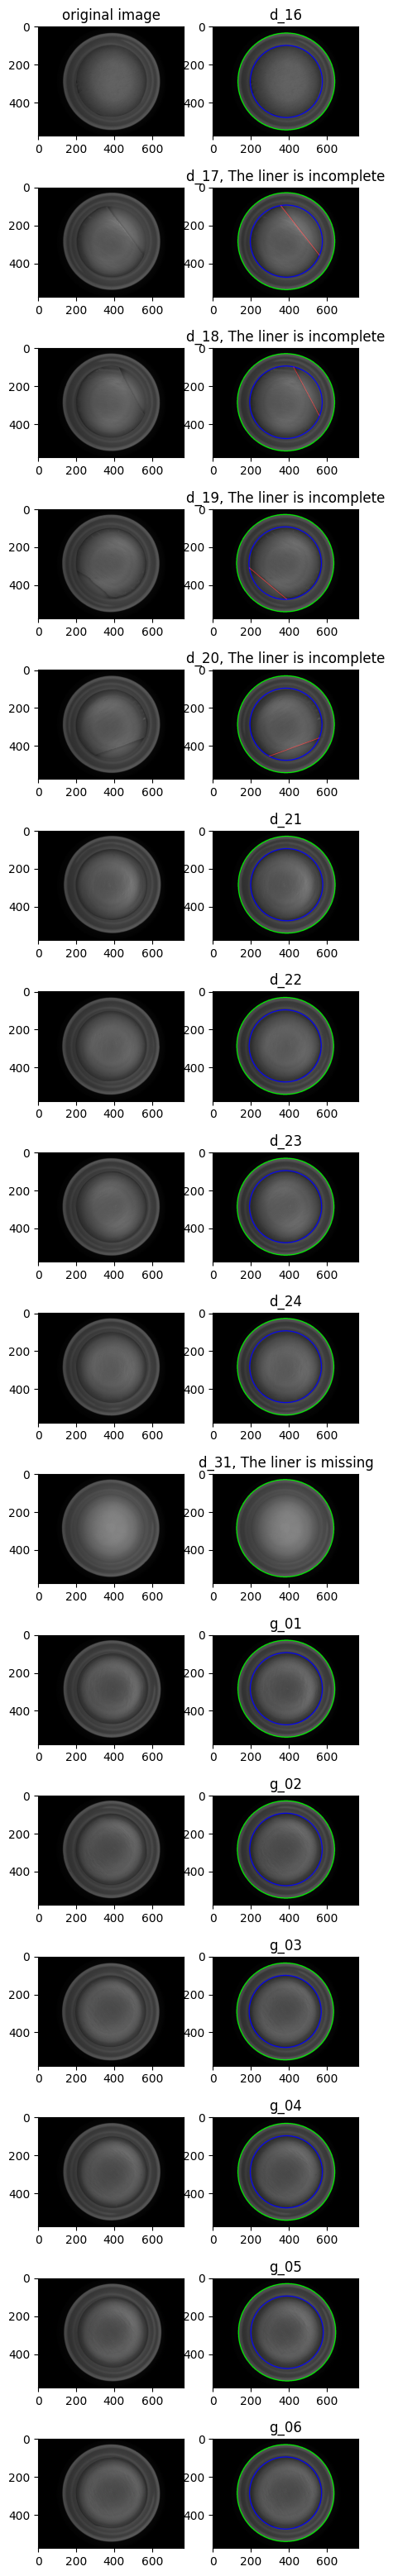

In [3]:
def hough_circle_kwargs(img):
    """
    Calculate and return the parameters for HoughCircles.

    Parameters:
    - img: Input image

    Returns:
    - Dictionary containing HoughCircles parameters
    """
    min_position, _ = np.unravel_index(np.argmin(img), img.shape)
    max_position = img.shape[0] - min_position
    radius = ((max_position - min_position) / 2)
    min_radius = int(radius - min_position)
    max_radius = int(radius + min_position)
    return dict(dp=1, minDist=50, param1=20, param2=100, minRadius=min_radius, maxRadius=max_radius)


def draw_cap_circle(image, cap_mouth_circle):
    """
    Draw the cap circle on the given image.

    Parameters:
    - image: Original image
    - cap_mouth_circle: Detected cap circle coordinates (x, y, r)
    """
    x, y, r = cap_mouth_circle
    cv2.circle(image, (x, y), r, (0, 255, 0), 4)


def create_circle_mask(image, center, radius):
    """
    Create a mask for the circle.

    Parameters:
    - image: Input image
    - center: Center of the circle
    - radius: Radius of the circle

    Returns:
    - Mask for the circle
    """
    mask = np.zeros_like(image)
    cv2.circle(mask, center, radius, (255, 255, 255), thickness=cv2.FILLED)
    return mask


def is_liner_missing(crop):
    """
    Gets a crop of binary image and checks whether the liner is missing by counting the black pixels,
    and comparing it to a threshold, which is 1000 pixels.

    Parameters:
    - crop: A crop of a binary image which is a little bigger than normal liners,
    and we can use it to see if the liner resides inside it.

    Returns:
    - True if there are not enough black pixels (the liner) within the cropped circle, False otherwise.
    """
    return np.unique(crop, return_counts=True)[1][0] - 322925 < 1000


def prepare_input(path):
    """
    Preprocess the given image to generate the necessary inputs.

    Parameters:
    - path: File path of the image

    Returns:
    - Tuple containing board,
        orig_image,
        image_board(to draw the results on),
        gray_image,
        blurred, and
        adaptive_thresholded_image
    """
    orig_image = cv2.imread(path, cv2.IMREAD_COLOR)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    image_board = orig_image.copy()
    gray_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    title = path.split("\\")[-1].split(".")[0]

    blurred = cv2.GaussianBlur(gray_image, (11, 11), 9)
    adaptive_thresholded_image = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2
    )

    return orig_image, image_board, gray_image, blurred, adaptive_thresholded_image, title


def process_image(path):
    """
    Process the given image for cap segmentation and defect detection.

    Parameters:
    - path: File path of the image

    Returns:
    - Tuple containing original image, processed image, and title
    """
    orig_image, board, gray_image, blurred, adaptive_thresholded_image, title = prepare_input(path)

    cap_mouth_circle = cv2.HoughCircles(
        blurred, cv2.HOUGH_GRADIENT, **hough_circle_kwargs(adaptive_thresholded_image)
    )[0, :]
    cap_mouth_circle = np.round(cap_mouth_circle).astype("int")[0]
    cap_mouth_center_x, cap_mouth_center_y, cap_mouth_radius = cap_mouth_circle
    liner_radius = cap_mouth_radius - 65
    liner_container_radius = cap_mouth_radius - 60
    defect_container_radius = cap_mouth_radius - 80
    draw_cap_circle(board, cap_mouth_circle)

    mask = create_circle_mask(
        adaptive_thresholded_image,
        (cap_mouth_center_x,
         cap_mouth_center_y),
        liner_container_radius)
    cropped_circle = cv2.bitwise_and(adaptive_thresholded_image, mask)

    if is_liner_missing(cropped_circle):
        title += ", The liner is missing"
    else:
        cv2.circle(board, (cap_mouth_center_x, cap_mouth_center_y), liner_radius, (0, 0, 255), 4)

    mask = create_circle_mask(
        adaptive_thresholded_image,
        (cap_mouth_center_x, cap_mouth_center_y),
        defect_container_radius
    )
    cropped_circle = cv2.bitwise_and(adaptive_thresholded_image, mask)

    canny = cv2.Canny(cropped_circle, 0, 10)
    lines = find_lines(canny)
    if lines is not None:
        title += ", The liner is incomplete"
        line = lines[0][-1]

        rho, theta = line
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * a)

        mask = np.zeros_like(board)
        new_img = board.copy()
        cv2.line(new_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.circle(mask,
                   (cap_mouth_center_x, cap_mouth_center_y),
                   liner_radius,
                   (255, 255, 255),
                   thickness=cv2.FILLED)
        cropped_circle = cv2.bitwise_and(new_img, mask)
        board[cropped_circle != 0] = cropped_circle[cropped_circle != 0]

    return orig_image, board, title


def find_lines(canny):
    """
    Find lines in the given Canny edge-detected image.

    Parameters:
    - canny: Canny edge-detected image

    Returns:
    - Detected lines
    """
    lines = None
    for j in range(50, 60):
        lines = cv2.HoughLines(canny, 1, np.pi / 180, threshold=j)
        if lines is None:
            continue
        if len(lines) < 5:
            break
    return lines


def main():
    """
    Main function to process images and display the results.
    """
    files_path = glob.glob('project_1_liner_inspection/*')
    n_rows = len(files_path)
    n_cols = 2
    plt.figure(figsize=(5, 40))
    flag = True
    for i in tqdm(range(len(files_path)), desc="Processing Images", unit="image"):
        path = files_path[i]
        orig_image, processed_image, title = process_image(path)

        plt.subplot(n_rows, n_cols, (i*2)+1), plt.imshow(orig_image), plt.title('original image') if flag else None
        plt.subplot(n_rows, n_cols, (i*2)+2), plt.imshow(processed_image), plt.title(title)
        flag = False

    plt.show()


if __name__ == "__main__":
    main()
